In [1]:
import pandas as pd 
import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Load model path into logic_ensemble object

In [2]:
model_path = '/home/spankaew/Git/astrologics/models/test_bonesis/'
model = le.LogicEnsemble(model_path, project_name = 'test_bonesis')
model.create_simulation()

Simulation object created


# Create simulation trajectory from the simulation
When we perform the simulation, the result of the timestep node activity can be visualized using dimension reduction method such as `pca`.

In [3]:
# setup initial state for the simulation
initial_state = {'Pax6':1}

In [4]:
test = pd.read_csv(model_path + 'bn0.bnet', sep = ',', header = None)
test[1] = 0.5
test_dict = dict(zip(test[0], test[1]))
test_dict

{'Aldh1L1': 0.5,
 'Brn2': 0.5,
 'Hes5': 0.5,
 'Mash1': 0.5,
 'Myt1L': 0.5,
 'Olig2': 0.5,
 'Pax6': 0.5,
 'Scl': 0.5,
 'Sox8': 0.5,
 'Stat3': 0.5,
 'Tuj1': 0.5,
 'Zic1': 0.5}

In [5]:
model.simulation.update_parameters(max_time = 20, sample_count = 5000)
model.simulation.run_simulation(initial_state = test_dict)

Start simulation


100%|██████████| 88/88 [00:18<00:00,  4.75it/s]


Simulation completed


Trajectory object created


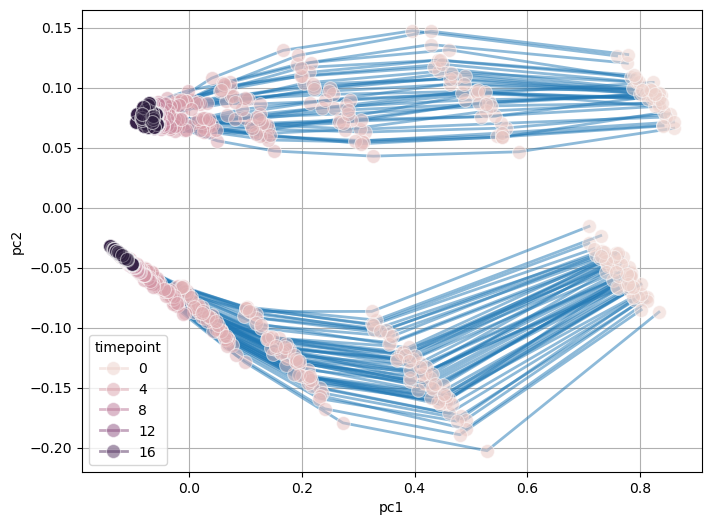

In [6]:
model.create_trajectory()
model.trajectory.pca_trajectory()
model.trajectory.plot_trajectory(color = 'timepoint', show_legend=True)

From the visualization, we can then try to group together models with simular simulation activity via clustering. 

In `logic_ensemble`, we utilize the package called `tslearn` - a toolkit to perform analysis on time series data. 

The timeseries clustering method included in this toolkit includes : 

- euclidean

- dynamic time warping (dtw) 

- softdtw.

The calculated clustering will be embeded into the trajectory matrix

In [7]:
import numpy as np
# Setup the 
pca_df = model.trajectory.pca_df
pca_df.model_id = pca_df.model_id.astype('category')
model_name = pca_df.model_id.cat.categories

simulation_df = model.simulation.simulation_df
simulation_df.model_id = simulation_df.model_id.astype('category')
node_list = simulation_df.columns.drop(['timepoint','model_id'])

model_original_all = {}
for i in model_name:
    model_original = simulation_df.loc[simulation_df.model_id == i,node_list].values
    model_original_all[i] = np.array(model_original)
pca_all_trajectory = np.array(list(model_original_all.values()))

In [8]:
from tslearn.metrics import dtw

# Initialize an empty distance matrix
num_trajectories = len(pca_all_trajectory)
distance_matrix = np.zeros((num_trajectories, num_trajectories))

# Calculate DTW distance for each pair of trajectories
for i in range(num_trajectories):
    for j in range(num_trajectories):
        distance_matrix[i, j] = dtw(pca_all_trajectory[i], pca_all_trajectory[j])

# Display the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, index=model_name, columns=model_name)

/tmp/ipykernel_104044/3815233600.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


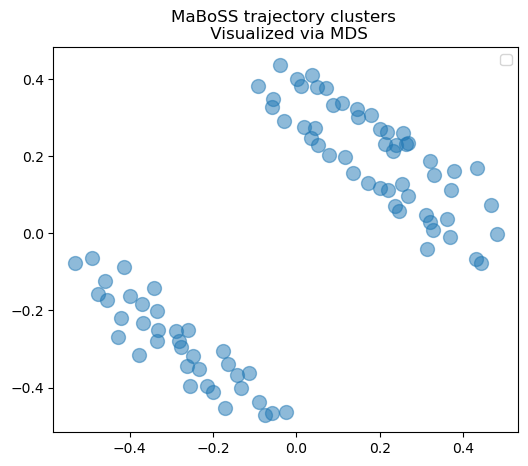

In [9]:
# Visualize clusters with MDS
from sklearn.manifold import MDS

# Visualize clusters with MDS
#distance_matrix = model.succession_diagram.distance_matrix
mds = MDS(dissimilarity='precomputed', random_state=12345)
coords = mds.fit_transform(distance_matrix)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5, s = 100)
plt.legend()
plt.title('MaBoSS trajectory clusters \n Visualized via MDS')
#plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/BonesisTutorial_trajMDS_v2.pdf')

plt.show()

plt.close()

In [10]:
# Get traj cluster
model.trajectory.calculate_kmean_cluster(n_cluster=2, data = 'original', metric = 'dtw')
cluster_dict_df = pd.DataFrame(list(model.trajectory.cluster_dict.items()), columns=['Model', 'traj_cluster'])
cluster_dict_df.set_index('Model', inplace=True)

coords_vis = pd.DataFrame(coords, columns = ['x', 'y'], index = distance_matrix.index)
coords_vis = pd.concat([coords_vis, cluster_dict_df],axis = 1)

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


DTW k-means
0.122 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.046 --> 0.046 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cl

In [11]:
coords_vis

,x,y,traj_cluster
bn0,0.217412,0.262915,0
bn1,0.263590,0.230356,0
bn10,-0.176464,-0.304333,1
bn11,-0.164025,-0.338829,1
bn12,0.146578,0.320824,0
...,...,...,...
bn84,-0.454132,-0.174058,1
bn85,-0.367513,-0.233334,1
bn86,-0.255357,-0.395485,1
bn87,-0.333534,-0.279498,1


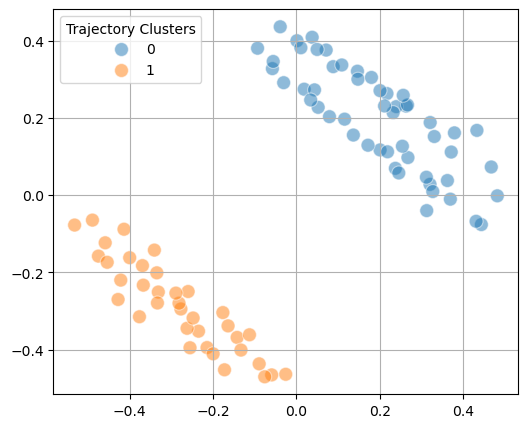

In [12]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=coords_vis, x='x', y='y', hue='traj_cluster', palette='tab10', alpha=0.5, s=100)
plt.xlabel(None)
plt.ylabel(None)
plt.legend(title='Trajectory Clusters')
plt.grid(None)
plt.show()
plt.close()

# Create logic function matrix
In this part of the script, we load models' logic function into a matrix. This matrix can then be transformed into a Disjunctive Normal Form (DNF) which allow us to identify clause of components that can activate each node. 

In [13]:
model.create_logic()
model.logic.model_logic
model.logic.create_flattend_logic_clause()

Loading models logics


100%|██████████| 88/88 [00:00<00:00, 626.48it/s]


Concatenate results into matrix


100%|██████████| 88/88 [00:00<00:00, 2365.35it/s]

Logic object created
Flatten models logic clauses



100%|██████████| 88/88 [00:00<00:00, 654430.41it/s]


Concatenate results into matrix


100%|██████████| 88/88 [00:00<00:00, 1609.93it/s]

Flattend logic clause created


# Notes
This part of the script should be convert into a function

- The selection of kmean_cluster cluster should be relatively simple to use

In [14]:
from sklearn.preprocessing import OrdinalEncoder
model_cluster = pd.Series(model.trajectory.pca_df.kmean_cluster, index=model.trajectory.pca_df.model_id)
model_logic = model.logic.model_logic

var_logic_clust = pd.DataFrame()
for i in list(model_cluster.unique()):
    model_logic_sub = model_logic.transpose().loc[list(model_cluster.index[model_cluster == i])]
    #model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(model_cluster.unique())

model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index

var_logic_clust= var_logic_clust.loc[sort_index] 

The main script that calculate the statistic between cluster is this script
Also, it use the `model.trajectory.cluster_dict` object to define the cluster.
- Finally, we use Chi-square as a statistical framework.

In [15]:
from scipy.stats import chi2_contingency

test = model.logic.logic_clause_flattend
test = test.transpose()
test['group'] = test.index.map(model.trajectory.cluster_dict)
# Assuming 'df' is a DataFrame with samples as rows and features as columns,
# and 'group' is a column indicating group membership.

# Step 1: Identify constant features.
constant_features = [col for col in test.columns if col != 'group' and test[col].nunique() == 1]

# Step 2 & 3: For non-constant features, perform chi-square test.
marker_features = []
varied_features = []

for col in test.columns:
    if col == 'group' or col in constant_features:
        continue
    contingency_table = pd.crosstab(test[col], test['group'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.0001:  # Adjust threshold as needed after multiple testing correction.
        marker_features.append(col)
    else:
        varied_features.append(col)

# Create a color palette for the groups
unique_groups = test['group'].unique()
palette = sns.color_palette("tab10", len(unique_groups))
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create a dictionary to store features and their groups
feature_groups = {
    'Feature': constant_features + varied_features + marker_features,
    'Group': (['Constant'] * len(constant_features)) +
             (['Varied'] * len(varied_features)) +
             (['Marker'] * len(marker_features))
}

# Convert the dictionary to a DataFrame
features_df = pd.DataFrame(feature_groups)

# Add the node features into the DataFrame
features_df['Node'] = features_df['Feature'].str.split('_', n=1, expand=True)[0]

In [16]:
from scipy.stats import chi2_contingency

test = model.logic.logic_clause_flattend
test = test.transpose()
test['group'] = test.index.map(model.trajectory.cluster_dict)
# Assuming 'df' is a DataFrame with samples as rows and features as columns,
# and 'group' is a column indicating group membership.

# Step 1: Identify constant features.
constant_features = [col for col in test.columns if col != 'group' and test[col].nunique() == 1]

# Step 2 & 3: For non-constant features, perform chi-square test.
marker_features = []
varied_features = []

for col in test.columns:
    contingency_table = pd.crosstab(test[col], test['group'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results = []
    for col in test.columns:
        if col == 'group':
            continue
        contingency_table = pd.crosstab(test[col], test['group'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        chi2_results.append({'feature': col, 'chi2': chi2, 'p_value': p})
    chi2_df = pd.DataFrame(chi2_results).set_index('feature')
    chi2_df['Node'] = [col.split('_')[0] if '_' in col else col for col in test.columns[:-1]]
    chi2_df['Regulation'] = [col.split('_')[1] if '_' in col else col for col in test.columns[:-1]]
chi2_df

,chi2,p_value,Node,Regulation
feature,,,,
Aldh1L1_(Stat3),0.000000,1.000000e+00,Aldh1L1,(Stat3)
Brn2_(Mash1),0.000000,1.000000e+00,Brn2,(Mash1)
Hes5_(!Mash1 & Pax6),0.000000,1.000000e+00,Hes5,(!Mash1 & Pax6)
Mash1_(!Hes5 & Pax6),0.000000,1.000000e+00,Mash1,(!Hes5 & Pax6)
Myt1L_(Olig2),83.911864,5.173315e-20,Myt1L,(Olig2)
Olig2_(Hes5 & !Scl),0.000000,1.000000e+00,Olig2,(Hes5 & !Scl)
Pax6_(Pax6),0.000000,1.000000e+00,Pax6,(Pax6)
Scl_(Hes5 & !Olig2),0.000000,1.000000e+00,Scl,(Hes5 & !Olig2)
Sox8_(Olig2),0.000000,1.000000e+00,Sox8,(Olig2)


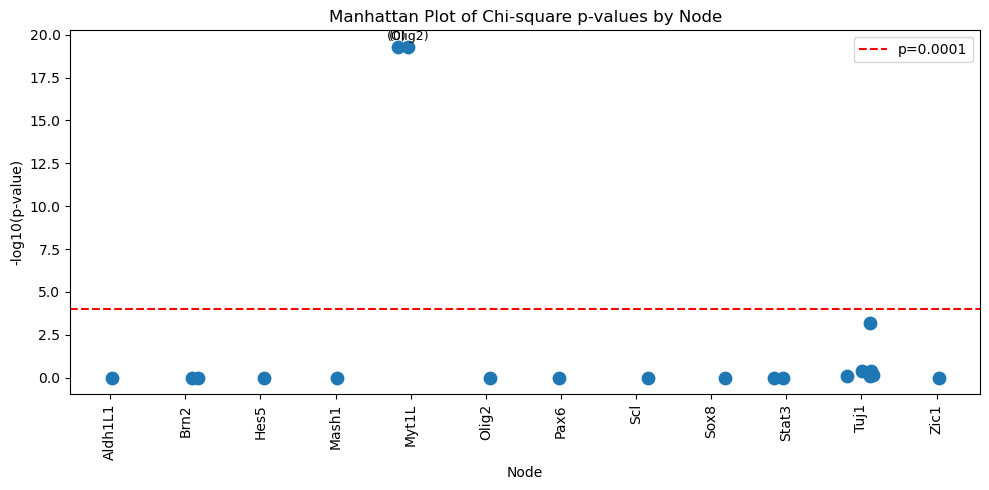

In [17]:
import numpy as np

plt.figure(figsize=(10, 5))
chi2_df['-log10_p'] = -np.log10(chi2_df['p_value'])

# Add jitter to x positions
nodes = chi2_df['Node'].astype('category')
x = nodes.cat.codes + np.random.uniform(-0.2, 0.2, size=len(chi2_df))

ax = plt.scatter(x, chi2_df['-log10_p'], s=80, color='tab:blue')

# Annotate points with Regulation if p-value < 0.0001
for i, row in chi2_df.iterrows():
    if row['p_value'] < 0.0001:
        plt.annotate(row['Regulation'], (x[i], row['-log10_p']),
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=9, color='black')

plt.axhline(-np.log10(0.0001), color='red', linestyle='--', label='p=0.0001')
plt.ylabel('-log10(p-value)')
plt.xlabel('Node')
plt.title('Manhattan Plot of Chi-square p-values by Node')
plt.xticks(ticks=range(len(nodes.cat.categories)), labels=nodes.cat.categories, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In this plot there are two components here

1. Barplot shows the variation of the logic function for each node
2. The barplot shows the number of clause that are the main distinctive clause in the model

/tmp/ipykernel_104044/3517451482.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_var_logic_length.index,
/tmp/ipykernel_104044/3517451482.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=sorted_var_logic_length.index,


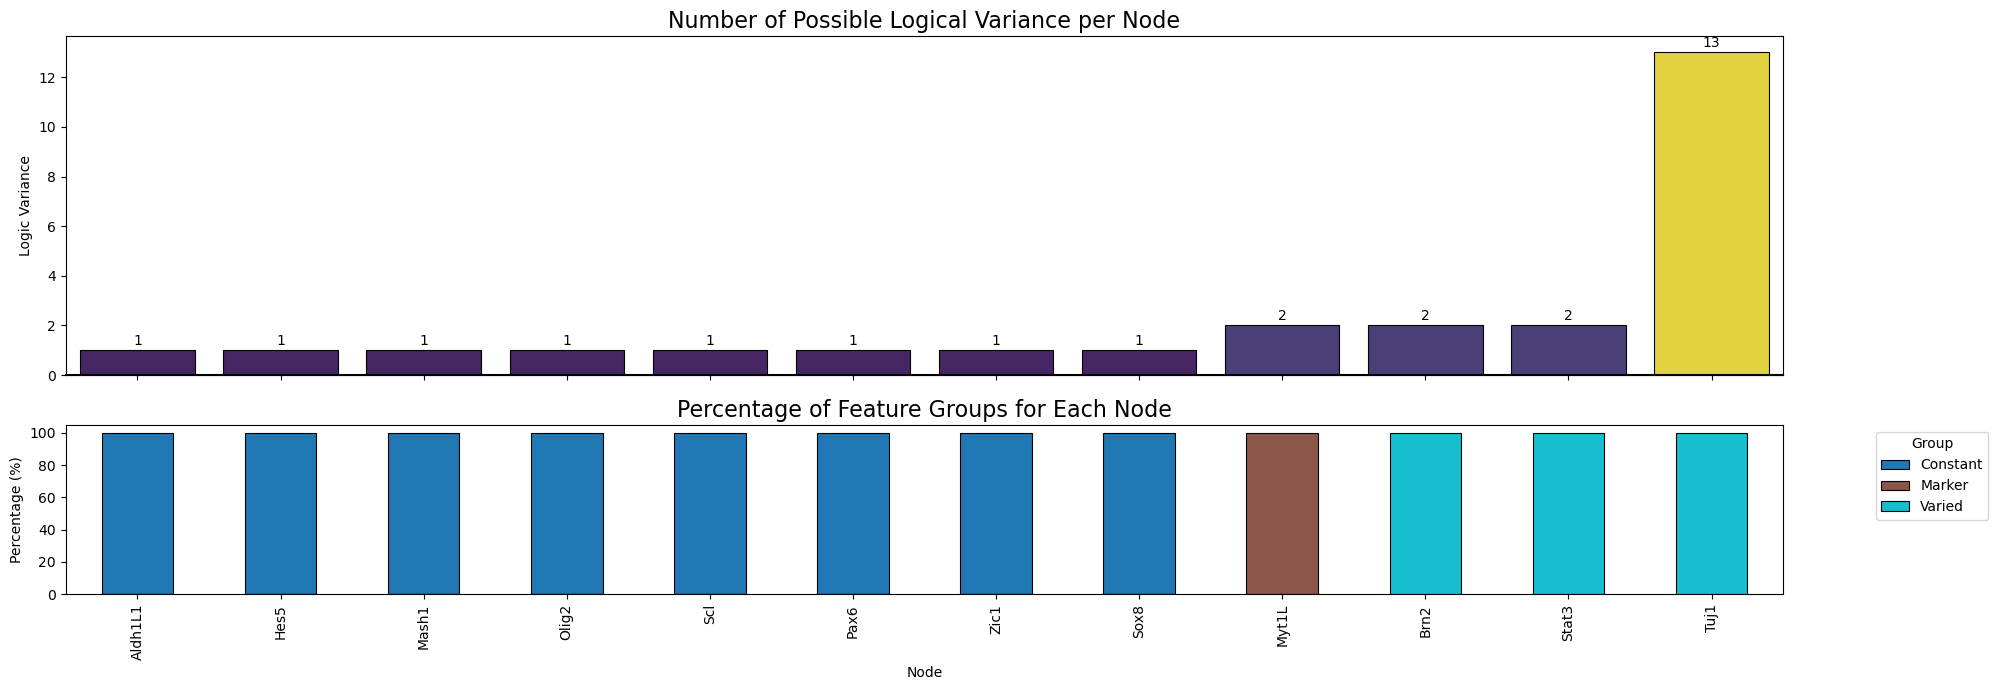

In [18]:
# Create a figure with two subplots sharing the x-axis
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot the first barplot
sorted_var_logic_length = encoded_df.max().sort_values() + 1
sns.barplot(x=sorted_var_logic_length.index, 
            y=sorted_var_logic_length.values, 
            palette=sns.color_palette("viridis", as_cmap=True)(sorted_var_logic_length.values / sorted_var_logic_length.max()), 
            edgecolor='black', linewidth=0.8, ax=axes[0])

# Customize the first plot
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel('Logic Variance')
axes[0].set_title('Number of Possible Logical Variance per Node', fontsize=16)
axes[0].tick_params(axis='x', rotation=90)
for index, value in enumerate(sorted_var_logic_length.astype('int')):
    axes[0].text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

# Plot the second stacked barplot
features_df_grouped = features_df.groupby(['Node', 'Group']).size().unstack(fill_value=0)
features_df_grouped = features_df_grouped.loc[sorted_var_logic_length.index]
features_df_percentage = features_df_grouped.div(features_df_grouped.sum(axis=1), axis=0) * 100
features_df_percentage.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[1], edgecolor='black', linewidth=0.8)

# Customize the second plot
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Node')
axes[1].set_title('Percentage of Feature Groups for Each Node', fontsize=16)
axes[1].legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

I think this is the best version of the barplot so far.

/tmp/ipykernel_104044/277780554.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_var_logic_length.index,
/tmp/ipykernel_104044/277780554.py:7: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=sorted_var_logic_length.index,


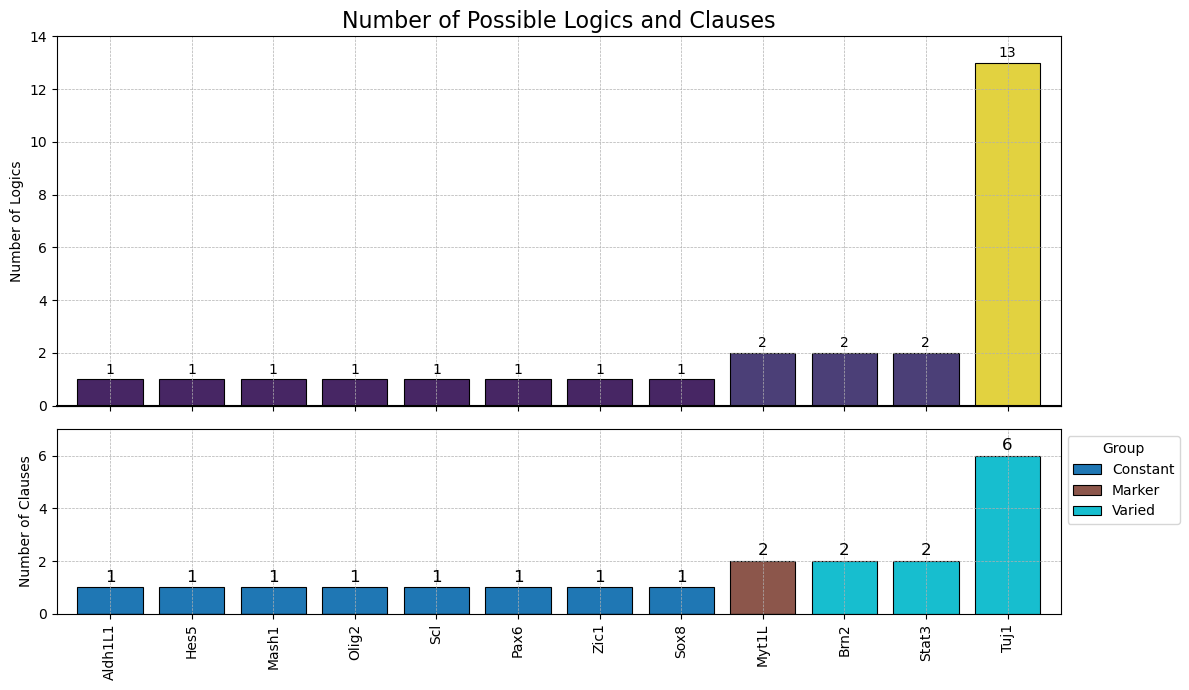

In [19]:
# Create a figure with two subplots sharing the x-axis
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot 1
## Plot the first barplot
sorted_var_logic_length = encoded_df.max().sort_values() + 1
sns.barplot(x=sorted_var_logic_length.index, 
            y=sorted_var_logic_length.values, 
            palette=sns.color_palette("viridis", as_cmap=True)(sorted_var_logic_length.values / sorted_var_logic_length.max()), 
            edgecolor='black', linewidth=0.8, ax=axes[0], width=0.8)
## Annotate the total number of logics
for index, value in enumerate(sorted_var_logic_length.astype('int')):
    axes[0].text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=10)
## Customize the first plot
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel('Number of Logics')
axes[0].set_title('Number of Possible Logics and Clauses', fontsize=16)
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylim(0, sorted_var_logic_length.max() + 1)
axes[0].grid( linestyle='--', linewidth=0.5)

# Plot 2
## Plot the second stacked barplot
features_df_grouped = features_df.groupby(['Node', 'Group']).size().unstack(fill_value=0)
features_df_grouped = features_df_grouped.loc[sorted_var_logic_length.index]
features_df_grouped.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[1], edgecolor='black', linewidth=0.8, width = 0.8)
## Annotate the total number of clauses
total_clauses = features_df_grouped.sum(axis=1)
for index, value in enumerate(total_clauses.astype('int')):
    axes[1].text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=12)
## Customize the second plot
axes[1].set_ylabel('Number of Clauses')
axes[1].set_xlabel(None)
axes[1].legend(title='Group', bbox_to_anchor=(1.0, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_ylim(0, features_df_grouped.values.max() + 1)
axes[1].grid(linestyle='--', linewidth=0.5)

# Ensure both subplots have the same x-ticks and labels
xticks = range(len(sorted_var_logic_length.index))
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(sorted_var_logic_length.index, rotation=90)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(sorted_var_logic_length.index, rotation=90)

plt.tight_layout()
plt.show()

/tmp/ipykernel_104044/2328310067.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_104044/2328310067.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


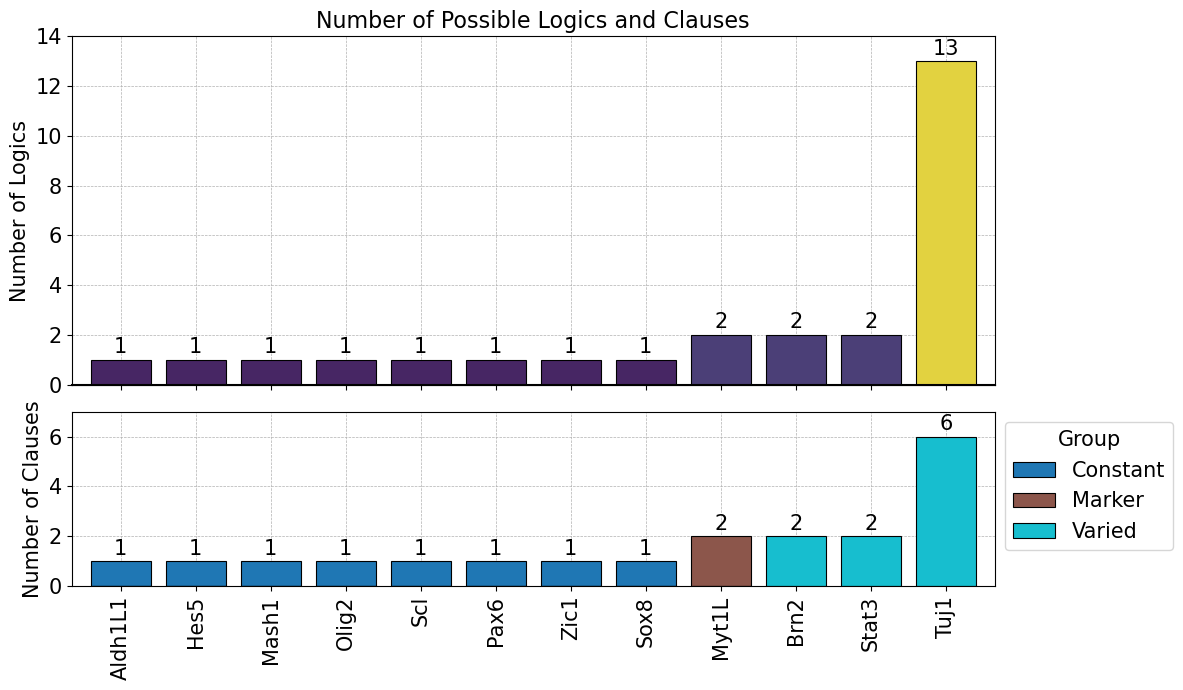

In [25]:
# Create a figure with two subplots sharing the x-axis
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot 1
## Plot the first barplot
sns.barplot(
    x=sorted_var_logic_length.index, 
    y=sorted_var_logic_length.values, 
    palette=sns.color_palette("viridis", as_cmap=True)(sorted_var_logic_length.values / sorted_var_logic_length.max()), 
    edgecolor='black', linewidth=0.8, ax=axes[0], width=0.8
)
## Annotate the total number of logics
for index, value in enumerate(sorted_var_logic_length.astype('int')):
    axes[0].text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=15)
## Customize the first plot
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel('Number of Logics', fontsize=15)
axes[0].set_title('Number of Possible Logics and Clauses', fontsize=16)
axes[0].tick_params(axis='x', rotation=90, labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].set_ylim(0, sorted_var_logic_length.max() + 1)
axes[0].grid(linestyle='--', linewidth=0.5)
axes[0].set_axisbelow(True)

# Plot 2
## Plot the second stacked barplot
features_df_grouped = features_df.groupby(['Node', 'Group']).size().unstack(fill_value=0)
features_df_grouped = features_df_grouped.loc[sorted_var_logic_length.index]
features_df_grouped.plot(
    kind='bar', stacked=True, colormap='tab10', ax=axes[1], edgecolor='black', linewidth=0.8, width=0.8
)
## Annotate the total number of clauses
total_clauses = features_df_grouped.sum(axis=1)
for index, value in enumerate(total_clauses.astype('int')):
    axes[1].text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=15)
## Customize the second plot
axes[1].set_ylabel('Number of Clauses', fontsize=15)
axes[1].set_xlabel(None)
axes[1].legend(title='Group', bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=15, title_fontsize=15)
axes[1].tick_params(axis='x', rotation=90, labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].set_ylim(0, features_df_grouped.values.max() + 1)
axes[1].grid(linestyle='--', linewidth=0.5)
axes[1].set_axisbelow(True)

# Ensure both subplots have the same x-ticks and labels
xticks = range(len(sorted_var_logic_length.index))
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(sorted_var_logic_length.index, rotation=90, fontsize=15)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(sorted_var_logic_length.index, rotation=90, fontsize=15)

plt.tight_layout()
plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/Bonesis_logic_features.png', dpi = 600, bbox_inches='tight')
plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/Bonesis_logic_features.pdf', bbox_inches='tight')
plt.show()
plt.close()

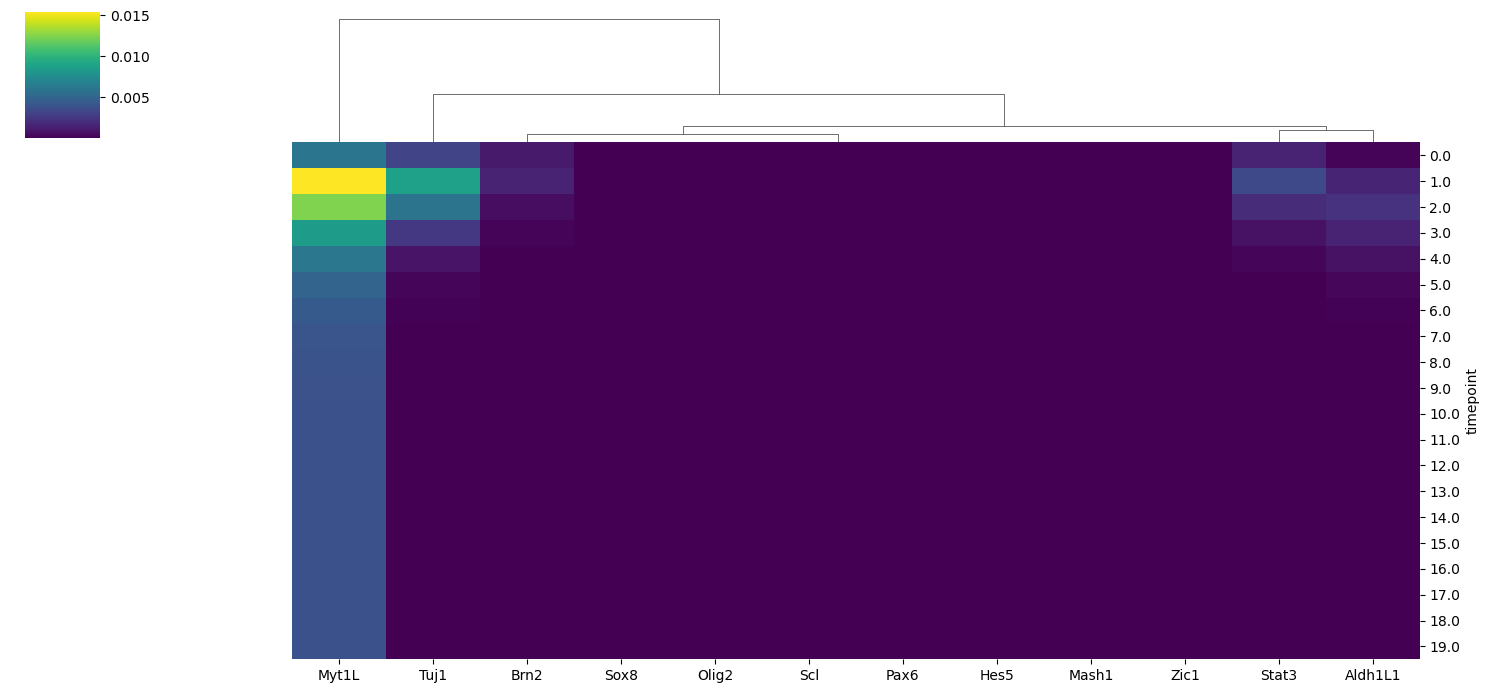

In [21]:
import pandas as pd

# Assuming `model_mtx` is your DataFrame with genes as columns and 'timepoint' as one of the columns
model_mtx = model.trajectory.simulation_df

# Group by 'timepoint' and calculate variance for each gene
variance_results = model_mtx.groupby('timepoint')[model_mtx.columns[:-2]].var()
variance_results['avg'] = variance_results.mean(axis = 1)
sns.clustermap(variance_results.drop(columns = ['avg']), row_cluster=False, cmap = 'viridis', figsize = (15,7))
plt.show()

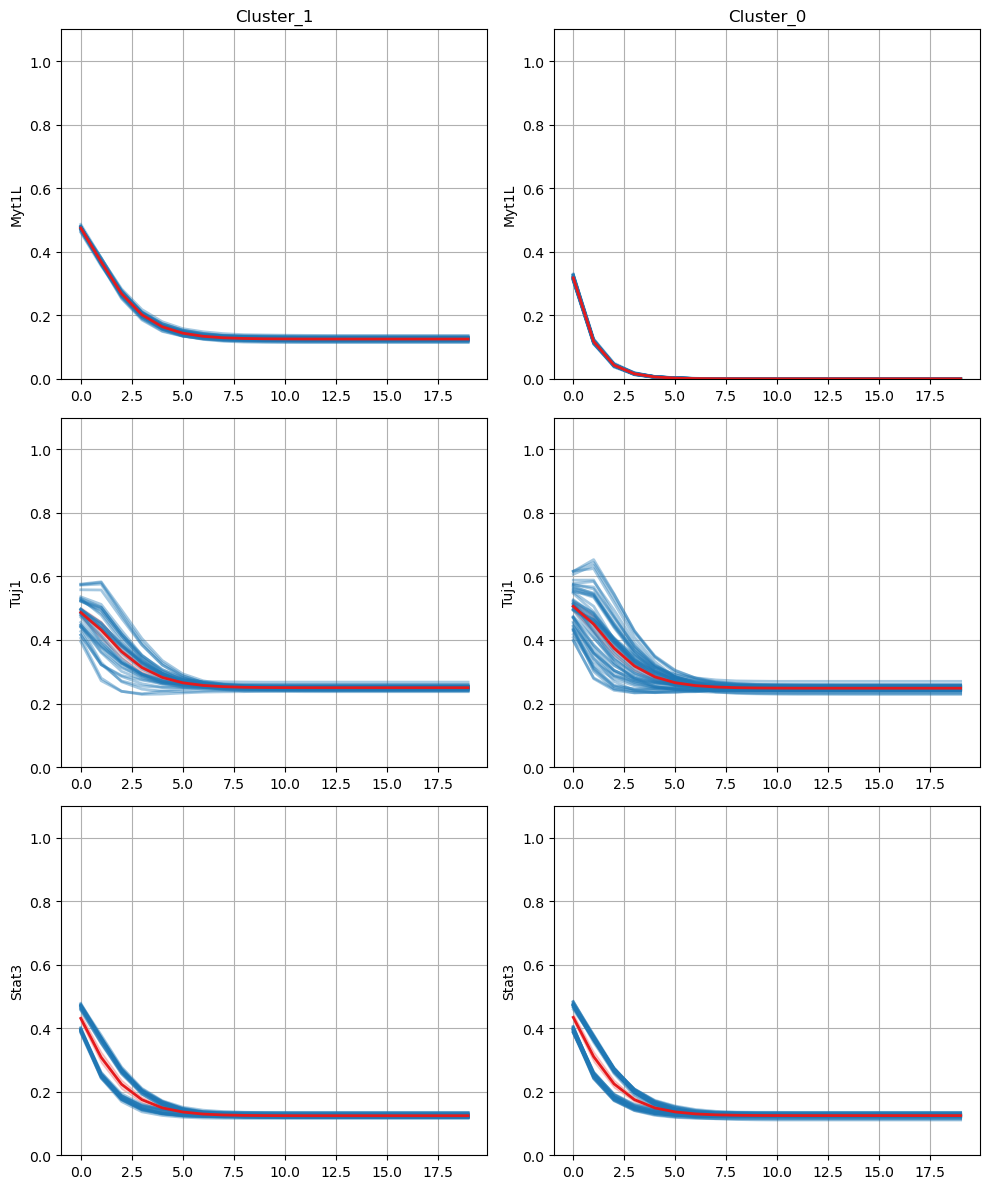

In [22]:
# Setup the gene list
selected_genes = ['Myt1L', 'Tuj1','Stat3']
num_timesteps = 20
model_mtx['type'] = model_mtx['model_id'].map(model.trajectory.cluster_dict)
cluster_type = list(model_mtx.type.unique())

# Function to create matrix for each condition
def create_vis_matrix(cluster_type):
    vis = model_mtx.loc[model_mtx['type'] == cluster_type]
    vis = vis[selected_genes + ['timepoint', 'model_id']]
    vis = vis[vis.timepoint.isin(range(0, num_timesteps))]
    vis['model_id'] = vis['model_id'].astype('str')
    vis['type'] = cluster_type
    return vis

# Create matrices for each condition
vis_matrices = [create_vis_matrix(i) for i in cluster_type]

# Plot with Seaborn
plt.figure(figsize=(len(cluster_type) * 5, len(selected_genes) * 4))
n_genes = len(selected_genes)

for i, gene in enumerate(selected_genes):
    for j, vis in enumerate(vis_matrices):
        plt.subplot(n_genes, len(cluster_type), len(cluster_type) * i + j + 1)
        plot = sns.lineplot(data=vis, x='timepoint', y=gene, lw=2, 
                            units = 'model_id', estimator = None, alpha = 0.4)
        plot.set_ylim(0, 1.1)
        plot.set_ylabel(gene)
        plot.set_xlabel(None)
        plot.grid(True)
        if i == 0:
            plot.set_title(f'Cluster_{cluster_type[j]}')
            
for i, gene in enumerate(selected_genes):
    for j, vis in enumerate(vis_matrices):
        plt.subplot(n_genes, len(cluster_type), len(cluster_type) * i + j + 1)
        plot = sns.lineplot(data=vis, x='timepoint', y=gene, lw=2, hue = 'type',palette='Set1')
        plot.set_ylim(0, 1.1)
        plot.set_ylabel(gene)
        plot.grid(True)
        plot.set_xlabel(None)
        plot.legend().remove()

plt.tight_layout()
plt.show()
plt.close()

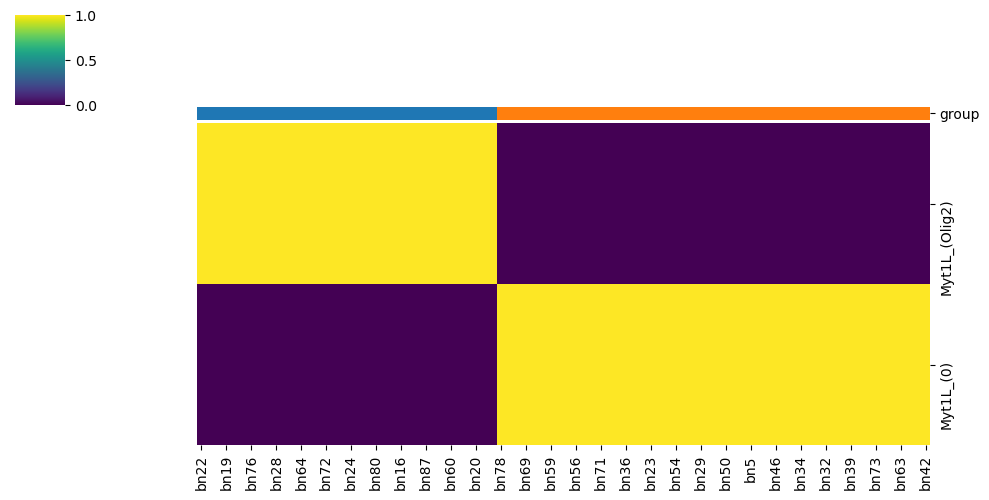

In [24]:
from scipy.cluster.hierarchy import linkage, leaves_list

selected_features = features_df.loc[(features_df['Node'] == 'Myt1L') & (features_df['Group'] == 'Marker')].Feature

# Create a color palette for the groups
unique_groups = test['group'].unique()
color_0 = sns.color_palette("tab10")[0]
color_2 = sns.color_palette("tab10")[1]
palette = [color_0,color_2]
group_colors = test['group'].map(dict(zip(unique_groups, palette)))

# Create the clustermap with row colors and separated cluster groups
# First, sort the DataFrame by cluster group to visually separate them
sorted_idx = test.sort_values('group').index

# Get the split point between the two clusters
split_point = (test.loc[sorted_idx, 'group'] == unique_groups[1]).idxmax()

# Perform row clustering only within each cluster group

# Cluster for group 0
group0_idx = test.loc[sorted_idx, 'group'] == unique_groups[0]
linkage0 = linkage(test.loc[sorted_idx[group0_idx], selected_features], method='average', metric='euclidean')
leaves0 = sorted_idx[group0_idx][leaves_list(linkage0)]

# Cluster for group 2
group2_idx = test.loc[sorted_idx, 'group'] == unique_groups[1]
linkage2 = linkage(test.loc[sorted_idx[group2_idx], selected_features], method='average', metric='euclidean')
leaves2 = sorted_idx[group2_idx][leaves_list(linkage2)]

# Concatenate the leaves to get the new row order
clustered_idx = leaves0.append(leaves2)

sns.clustermap(
    test.loc[clustered_idx, selected_features].transpose(),
    col_cluster=False,
    row_cluster=False,
    cmap='viridis',
    figsize=(10, 5),
    col_colors=group_colors.loc[clustered_idx]
)

plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/Bonesis_heatmap_logic_Myt1L.png', dpi = 500, bbox_inches='tight')
plt.savefig('/home/spankaew/Git/astrologics/figures/model_clusters/Bonesis_heatmap_logic_Myt1L.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [20]:
model_cluster = pd.Series(model.trajectory.cluster_dict)
test = model.logic.logic_clause_flattend
result_df = pd.DataFrame()

for cluster in model.trajectory.cluster_dict.values():
    cluster_id = [key for key, value in model.trajectory.cluster_dict.items() if value == cluster]
    cluster_mtx = test.loc[:, test.columns.isin(cluster_id)]
    cluster_mean = cluster_mtx.mean(axis=1)
    result_df[f'Cluster_{cluster}'] = cluster_mean
result_df

,Cluster_0,Cluster_1
Aldh1L1_(Stat3),1.000000,1.000000
Brn2_(Mash1),0.500000,0.500000
Hes5_(!Mash1 & Pax6),1.000000,1.000000
Mash1_(!Hes5 & Pax6),1.000000,1.000000
Myt1L_(Olig2),0.000000,1.000000
Olig2_(Hes5 & !Scl),1.000000,1.000000
Pax6_(Pax6),1.000000,1.000000
Scl_(Hes5 & !Olig2),1.000000,1.000000
Sox8_(Olig2),1.000000,1.000000
Stat3_(Scl),0.500000,0.500000


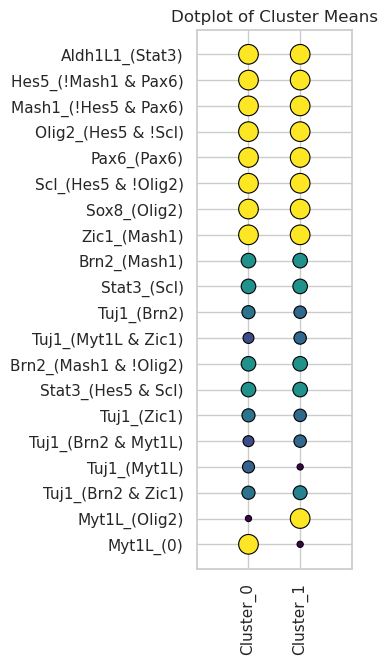

In [21]:
model_cluster = pd.Series(model.trajectory.cluster_dict)
test = model.logic.logic_clause_flattend
result_df = pd.DataFrame()

for cluster in model.trajectory.cluster_dict.values():
    cluster_id = [key for key, value in model.trajectory.cluster_dict.items() if value == cluster]
    cluster_mtx = test.loc[:, test.columns.isin(cluster_id)]
    cluster_mean = cluster_mtx.mean(axis=1)
    result_df[f'Cluster_{cluster}'] = cluster_mean

# Convert the result_df to a long format for easier plotting with seaborn
result_df = result_df.loc[constant_features + varied_features + marker_features,:]
result_long_df = result_df.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Value')

# Create the dot plot
plt.figure(figsize=(2, 7))
sns.set_theme(style="whitegrid")
dotplot = sns.scatterplot(data=result_long_df, 
                          x=pd.Categorical(result_long_df['Cluster'], categories=['Cluster_0', 'Cluster_1'], ordered=True), 
                          y='index', 
                          size='Value', hue='Value', 
                          palette='viridis', sizes=(20, 200), legend=None,
                          edgecolor='black', linewidth=0.8)

# Customize the plot
plt.title('Dotplot of Cluster Means')
#plt.xlabel('Cluster')
plt.ylabel(None)
plt.xticks(rotation=90)
plt.xlim(-1,2)
plt.savefig('/home/spankaew/Git/astrologics/figures/BonesisTutorial_traj_dotplot.pdf', bbox_inches='tight')

plt.show()
plt.close()